# Set up env

**REQUIRES CUDA 12.1**

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt install git-lfs -y

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.10
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.5.1).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


In [2]:
!git clone https://huggingface.co/lmsys/vicuna-7b-v1.1 ./llm/vicuna-7b

Cloning into './llm/vicuna-7b'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), 10.28 KiB | 1.47 MiB/s, done.
Filtering content: 100% (3/3), 4.55 GiB | 70.65 MiB/s, done.


In [ ]:
import torchshow

#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [4]:
import sys
import os
import torch
import numpy as np
from lavis.models import load_model_and_preprocess

import decord
from decord import VideoReader
from decord import cpu, gpu
decord.bridge.set_bridge('torch')

#### Load an example video

In [5]:
def load_video(vr, start_time, end_time, fps, num_frames=20):
    start_index = int(round(start_time * fps))
    end_index = int(round(end_time * fps))
    select_frame_index = np.rint(np.linspace(start_index, end_index-1, num_frames)).astype(int).tolist()
    frames = vr.get_batch(select_frame_index).permute(3, 0, 1, 2).to(torch.float32)
    return frames

file_path = "example/video.mp4"
vr = VideoReader(file_path, ctx=cpu(0))
total_frames = len(vr)
fps = vr.get_avg_fps()
duration = total_frames / fps

print("video_duration: {:.1f}, fps: {:.1f}".format(duration, fps))

video_duration: 70.3, fps: 24.0


In [6]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(device)

cuda


#### Visualize the full video

In [7]:
from IPython.display import HTML

# Embed video using HTML
HTML("""
<video width="640" height="480" controls>
  <source src="example/video.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>
""")

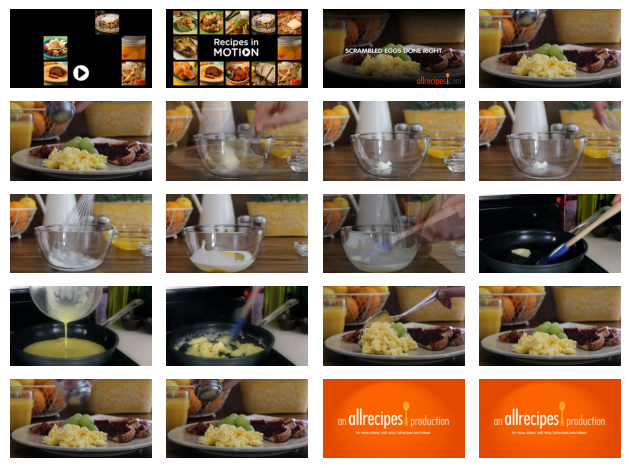

In [9]:
video = load_video(vr, start_time=0, end_time=duration, fps=fps, num_frames=20)

torchshow.show(video.squeeze().transpose(0,1))

#### Load pre-trained InstructBlip model weights

In [10]:
# We associate a model with its preprocessors to make it easier for inference.
# You can specify the memory_bank_length and num_frames here.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_vicuna_instruct_malmm", model_type="vicuna7b", is_eval=True, device=device, memory_bank_length=10, num_frames=20,
)
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_vicuna_instruct_malmm", model_type="vicuna13b", is_eval=True, device=device, memory_bank_length=10, num_frames=20,
# )

INFO:timm.models.hub:Downloading: "https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/eva_vit_g.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/eva_vit_g.pth

100%|██████████| 1.89G/1.89G [00:07<00:00, 287MB/s]
INFO:root:freeze vision encoder
INFO:root:BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): MBBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (out

#### Load finetuned model weights

In [11]:
# Model loads the default config from lavis/configs/models/blip2/blip2_instruct_vicuna7b.yaml.
# If you want to load a finetuned checkpoints, such as the finetuned model weight of ActivityNet-QA dataset,
# you need to first set the load_finetuned=True and specify the finetuned checkpoint path and reload the model again.

# load_finetuned: True
# finetuned: "saved_model/ActivityNet_qa/checkpoint_best.pth"

# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_vicuna_instruct_malmm", model_type="vicuna7b", is_eval=True, device=device, memory_bank_length=10, num_frames=20,
# )

10
20


#### Instructed zero-shot video-to-language generation

In [12]:
# load video by specifying the start_time and end_time
video = load_video(vr, start_time=0, end_time=duration, fps=fps, num_frames=20)
# prepare the video as model input using the associated processors
video = vis_processors["eval"](video).to(device).unsqueeze(0)
model.generate({"image": video, "prompt": "Question: what is the recipe of this video? Answer:"})

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['scrambled eggs']

#### Online off-the-shelf setting with custom questions

In [13]:
video = load_video(vr, start_time=0, end_time=37, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)
model.generate({"image": video, "prompt": "Question: what will happen for the next 5 seconds? Answer:"})

['eggs will be scrambled']

#### Generate multiple answers

In [14]:
video = load_video(vr, start_time=0, end_time=duration, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)
model.generate({"image": video, "prompt": "Question: what does this video show? Answer:"}, num_captions=5)

['cooking', 'recipe', 'egg recipe', 'cooking eggs', 'egg recipe production']

# My testing: short example

In [31]:
file_path = "example/short.mp4"
vr = VideoReader(file_path, ctx=cpu(0))
total_frames = len(vr)
fps = vr.get_avg_fps()
duration = total_frames / fps

print("video_duration: {:.1f}, fps: {:.1f}".format(duration, fps))

HTML("""
<video width="640" height="480" controls>
  <source src="example/short.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>
""")

video_duration: 4.0, fps: 30.0


['man', 'person', 'wii', 'man playing wii', 'man playing video game']

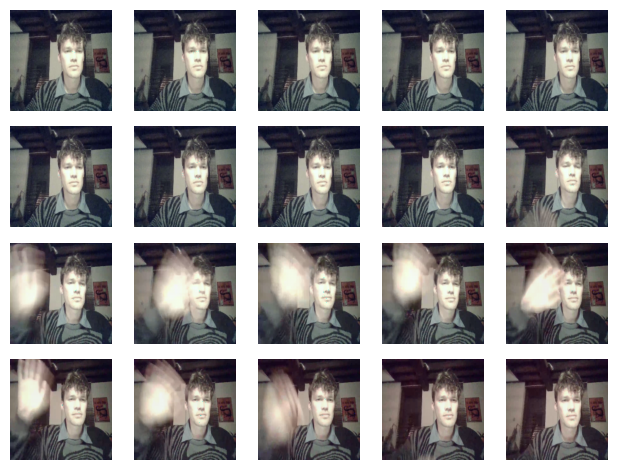

In [35]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what does this video show? Answer:"},
     num_captions=5
)

['nothing',
 'he wiped his nose',
 'he wiped his face',
 'he wiped his forehead',
 'he wiped his hand']

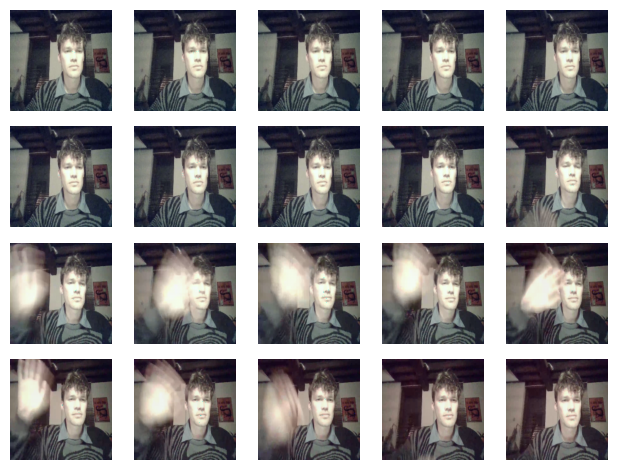

In [38]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happened in the last 2 seconds? Answer:"},
     num_captions=5
)

['nothing', 'he blinked', 'hand waving', 'man waving', 'he blinks']

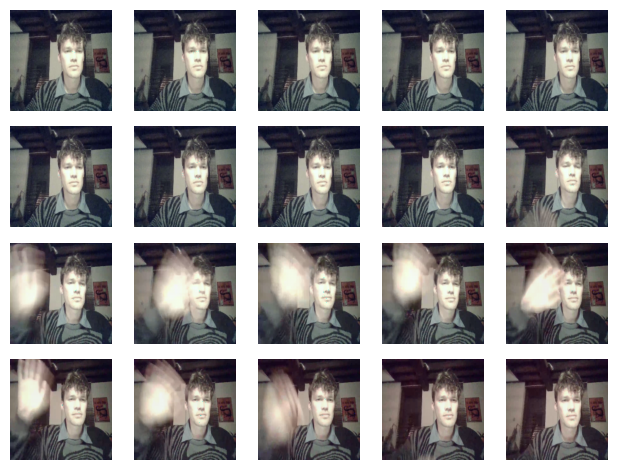

In [47]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happens in the last 10 frames? Answer:"},
     num_captions=5
)

['nothing', 'man waving', 'hand waving', 'blur', 'blink']

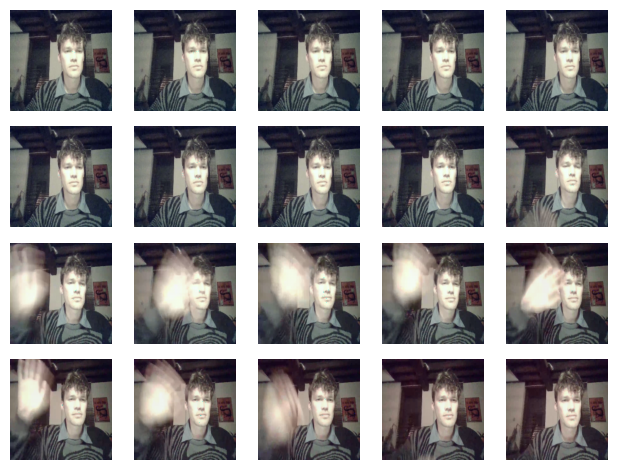

In [48]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happens in the last 20 frames? Answer:"},
     num_captions=5
)

['The man is waving his hand in front of his face',
 'The man raises his hand in front of his face',
 'The man raises his hand',
 'man raises hand',
 'The man is waving his hand in front of his face.']

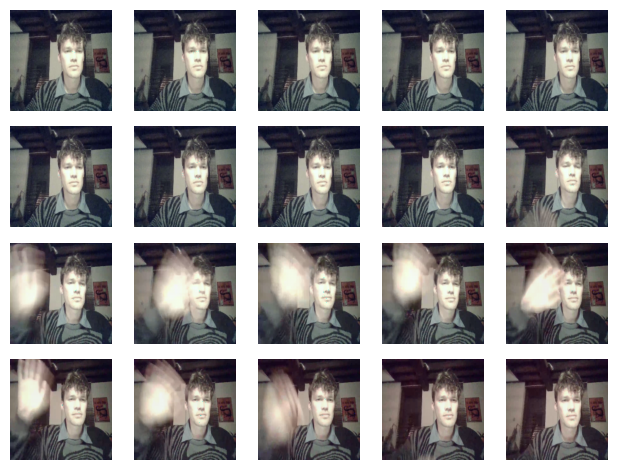

In [53]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "What happens in the last 3 frames?"},
     num_captions=5
)

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


["In the video, a young man is wearing a sweater and standing in front of a wooden wall. He appears to be holding something in his hand, possibly a cell phone or a remote control. There are two potted plants visible in the background, one on the left side and another on the right side of the room. Additionally, there are two books placed on the wooden wall, one on the left side and another on the right side of the room. The man's face is partially obscured by his hair, making it difficult to determine his facial expression.",
 'In the video, a young man is wearing a sweater and standing in front of a wooden wall. He appears to be holding something in his hand, possibly a cell phone or a remote control. There are two potted plants visible in the background, one on the left side and another on the right side of the room. Additionally, there are two books placed on the wooden wall, one on the left side and another on the right side of the room.',
 'In the video, a young man is wearing a s

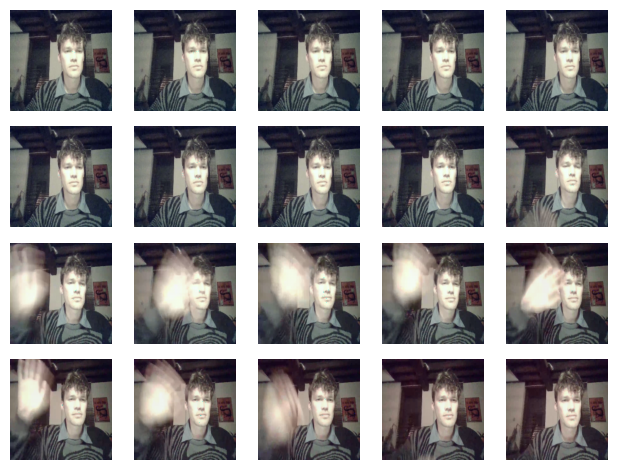

In [51]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Describe this video."},
     num_captions=5
)

# My testing: long example

In [54]:
file_path = "example/test.mp4"
vr = VideoReader(file_path, ctx=cpu(0))
total_frames = len(vr)
fps = vr.get_avg_fps()
duration = total_frames / fps

print("video_duration: {:.1f}, fps: {:.1f}".format(duration, fps))

HTML("""
<video width="640" height="480" controls>
  <source src="example/test.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>
""")

video_duration: 62.1, fps: 30.0


['man', 'person', 'man in front of camera', 'man in room', 'blurry man']

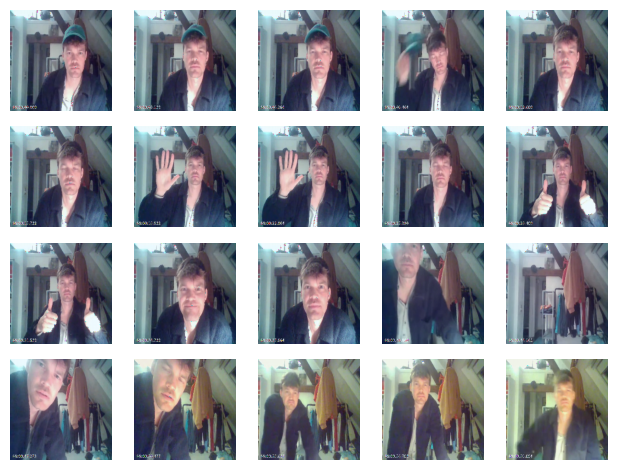

In [55]:
video = load_video(vr, start_time=0, end_time=60, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what does this video show? Answer:"},
     num_captions=5
)

['nothing',
 'photo taken',
 'man took picture',
 'picture taken',
 'he took picture']

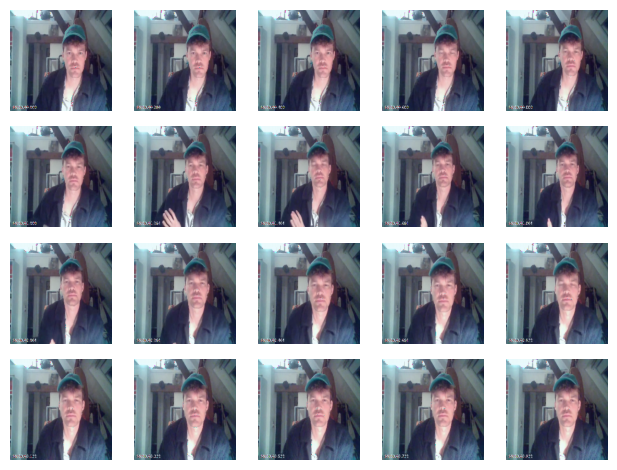

In [56]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happened in the last 2 seconds? Answer:"},
     num_captions=5
)

['nothing', "man's face", 'man frowns', 'man frowning', 'man blinked']

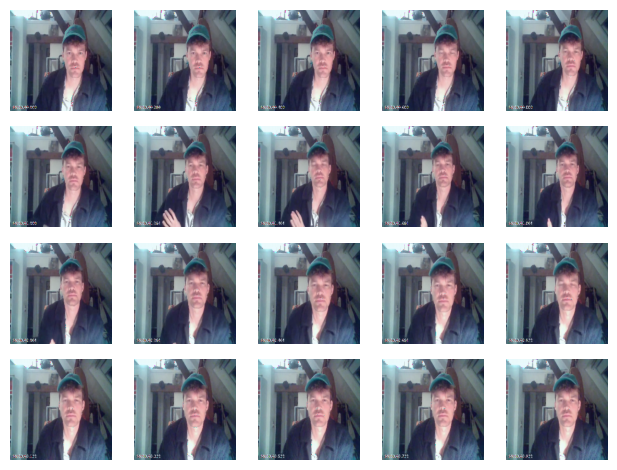

In [57]:
video = load_video(vr, start_time=0, end_time=4, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happens in the last 10 frames? Answer:"},
     num_captions=5
)

['10 seconds', '15 seconds', '30 seconds', '5 seconds', '2 minutes']

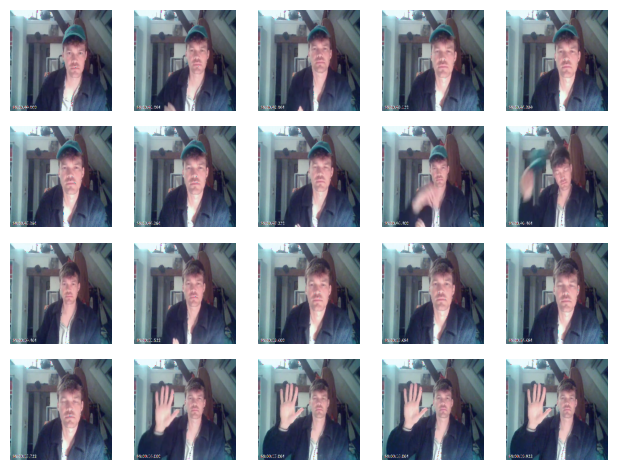

In [65]:
video = load_video(vr, start_time=0, end_time=20, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: how long is the video? Answer:"},
     num_captions=5
)

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['nothing', 'blink', 'man looks at camera', 'man takes picture', 'man is looking at camera']


['he blinked', 'man blinked', 'nothing', "man's eyes closed", "man's face"]

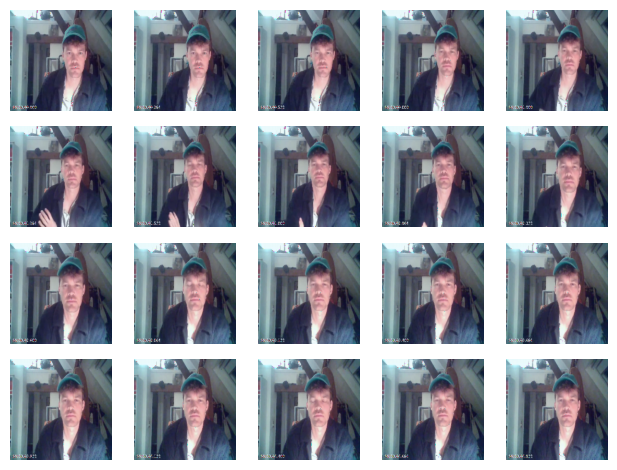

In [79]:
video = load_video(vr, start_time=0, end_time=5, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

print(model.generate(
    {"image": video,
     "prompt": "Question: what happens in the first 5 frames? Answer:"},
     num_captions=5
))

model.generate(
    {"image": video,
     "prompt": "Question: what happens in the last 5 frames? Answer:"},
     num_captions=5
)

['nothing', 'man takes hat off', 'man puts hat on', 'man puts on hat', 'hat on head']


['man flips hat',
 'man put hat on',
 'man flips his hat',
 'man puts hat on',
 'man put on hat']

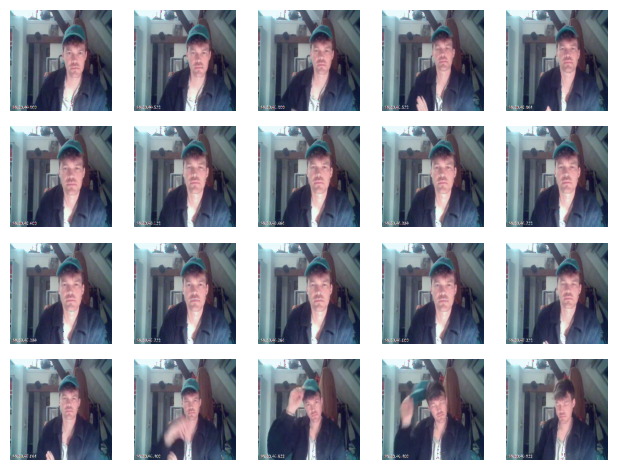

In [80]:
video = load_video(vr, start_time=0, end_time=10, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

print(model.generate(
    {"image": video,
     "prompt": "Question: what happens in the first 5 frames? Answer:"},
     num_captions=5
))

model.generate(
    {"image": video,
     "prompt": "Question: what happens in the last 5 frames? Answer:"},
     num_captions=5
)

['nothing', 'man takes hat off', 'man looks at camera', 'man is looking at camera', 'man takes hat off his head']


['man flips hat',
 'man wiping his nose',
 'man wiping nose',
 'man put hat on',
 'man flips his hair']

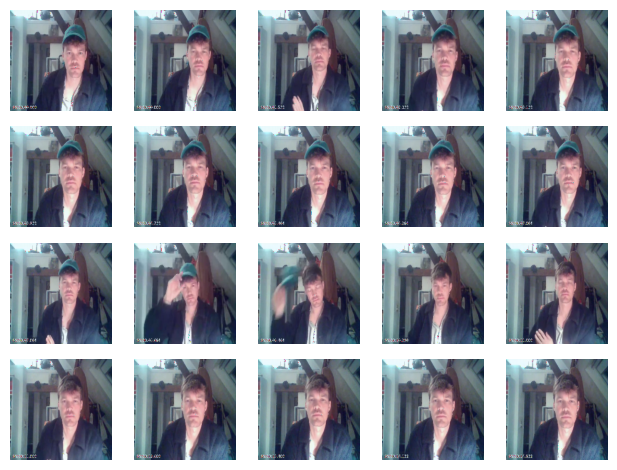

In [81]:
video = load_video(vr, start_time=0, end_time=15, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

print(model.generate(
    {"image": video,
     "prompt": "Question: what happens in the first 5 frames? Answer:"},
     num_captions=5
))

model.generate(
    {"image": video,
     "prompt": "Question: what happens in the last 5 frames? Answer:"},
     num_captions=5
)

['nothing',
 'he wiped his nose',
 'he wiped his face',
 'man waved',
 'man waving']

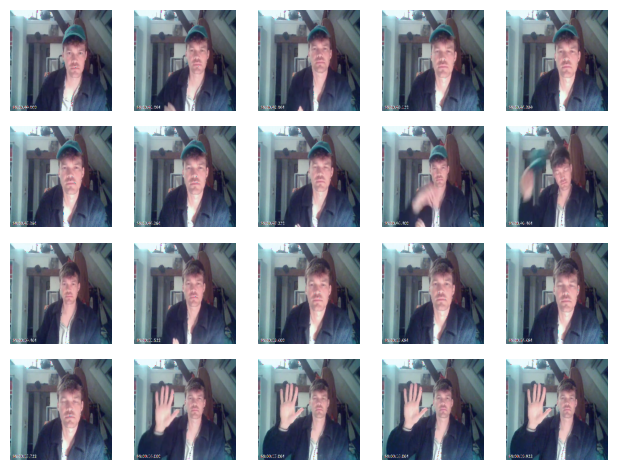

In [82]:
video = load_video(vr, start_time=0, end_time=20, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happened in the last 5 frames? Answer:"},
     num_captions=5
)

['nothing']

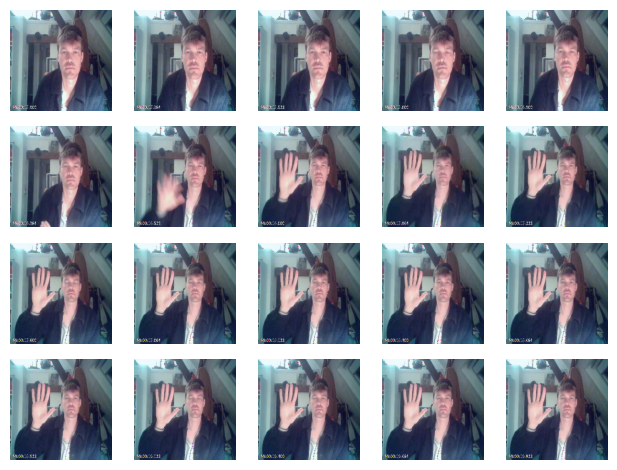

In [88]:
video = load_video(vr, start_time=15, end_time=20, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happened in the last 5 frames? Answer:"},
     num_captions=1
)

In [93]:
model.generate(
    {"image": video,
     "prompt": "Question: when does the man start waving? Answer:"},
     num_captions=5
)

['yes', 'after taking picture', '0 seconds', 'no', '10 seconds']

['selfie', 'video chat', 'hair cut', 'video call', 'video game']

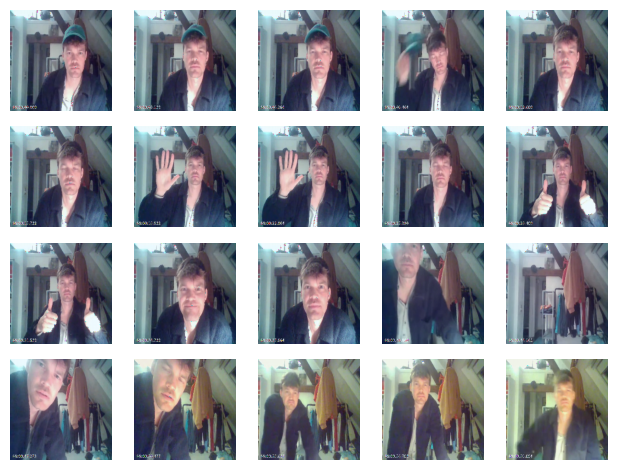

In [102]:
video = load_video(vr, start_time=0, end_time=60, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))


model.generate(
    {"image": video,
     "prompt": "Question: what is this about? Answer:"},
     num_captions=5
)

['A man is standing in front of a camera and making a funny face. He is wearing a jacket and a baseball cap. There are clothes hanging on a rack in the background.',
 'A man is standing in front of a camera and making a funny face. He is wearing a jacket and a hat. There are clothes hanging on a rack in the background.',
 'A man is standing in front of a camera and making a funny face. He is wearing a jacket and a baseball cap. There are clothes hanging on a rack behind him.',
 'A man is standing in front of a camera and making a funny face. He is wearing a jacket and a hat. There are clothes hanging on a rack behind him.',
 'A man is standing in front of a camera and making a funny face. He is wearing a jacket and a hat. There are clothes hanging on the wall behind him.']

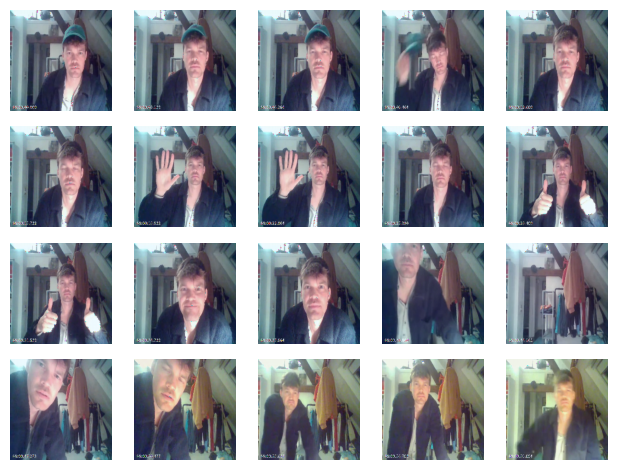

In [116]:
video = load_video(vr, start_time=0, end_time=60, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))


model.generate(
    {"image": video,
     "prompt": "Caption?"},
     num_captions=5
)